In [1]:
from collections import defaultdict
from dataclasses import dataclass
from typing import List

import cv2
import numpy as np
from sklearn.cluster import DBSCAN

In [2]:
@dataclass
class BBox:
    x: int
    y: int
    w: int
    h: int


@dataclass
class DetectorRes:
    img: np.ndarray
    bbox: BBox


def detect(img: np.ndarray,
           kernel_size: int,
           sigma: float,
           theta: float,
           min_area: int) -> List[DetectorRes]:
    """Scale space technique for word segmentation proposed by R. Manmatha.
    For details see paper http://ciir.cs.umass.edu/pubfiles/mm-27.pdf.
    Args:
        img: A grayscale uint8 image.
        kernel_size: The size of the filter kernel, must be an odd integer.
        sigma: Standard deviation of Gaussian function used for filter kernel.
        theta: Approximated width/height ratio of words, filter function is distorted by this factor.
        min_area: Ignore word candidates smaller than specified area.
    Returns:
        List of DetectorRes instances, each containing the bounding box and the word image.
    """
    assert img.ndim == 2
    assert img.dtype == np.uint8

    # apply filter kernel
    kernel = _compute_kernel(kernel_size, sigma, theta)
    img_filtered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    img_thres = 255 - cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # append components to result
    res = []
    components = cv2.findContours(img_thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    for c in components:
        # skip small word candidates
        if cv2.contourArea(c) < min_area:
            continue
        # append bounding box and image of word to result list
        x, y, w, h = cv2.boundingRect(c)  # bounding box as tuple (x, y, w, h)
        crop = img[y:y + h, x:x + w]
        res.append(DetectorRes(crop, BBox(x, y, w, h)))

    return res


def _compute_kernel(kernel_size: int,
                    sigma: float,
                    theta: float) -> np.ndarray:
    """Compute anisotropic filter kernel."""

    assert kernel_size % 2  # must be odd size

    # create coordinate grid
    half_size = kernel_size // 2
    xs = ys = np.linspace(-half_size, half_size, kernel_size)
    x, y = np.meshgrid(xs, ys)

    # compute sigma values in x and y direction, where theta is roughly the average x/y ratio of words
    sigma_y = sigma
    sigma_x = sigma_y * theta

    # compute terms and combine them
    exp_term = np.exp(-x ** 2 / (2 * sigma_x) - y ** 2 / (2 * sigma_y))
    x_term = (x ** 2 - sigma_x ** 2) / (2 * np.math.pi * sigma_x ** 5 * sigma_y)
    y_term = (y ** 2 - sigma_y ** 2) / (2 * np.math.pi * sigma_y ** 5 * sigma_x)
    kernel = (x_term + y_term) * exp_term

    # normalize and return kernel
    kernel = kernel / np.sum(kernel)
    return kernel


def prepare_img(img: np.ndarray,
                height: int) -> np.ndarray:
    """Convert image to grayscale image (if needed) and resize to given height."""
    assert img.ndim in (2, 3)
    assert height > 0
    assert img.dtype == np.uint8
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = img.shape[0]
    factor = height / h
    return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def _cluster_lines(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    # compute matrix containing Jaccard distances (which is a proper metric)
    num_bboxes = len(detections)
    dist_mat = np.ones((num_bboxes, num_bboxes))
    for i in range(num_bboxes):
        for j in range(i, num_bboxes):
            a = detections[i].bbox
            b = detections[j].bbox
            if a.y > b.y + b.h or b.y > a.y + a.h:
                continue
            intersection = min(a.y + a.h, b.y + b.h) - max(a.y, b.y)
            union = a.h + b.h - intersection
            iou = np.clip(intersection / union if union > 0 else 0, 0, 1)
            dist_mat[i, j] = dist_mat[j, i] = 1 - iou  # Jaccard distance is defined as 1-iou

    dbscan = DBSCAN(eps=max_dist, min_samples=min_words_per_line, metric='precomputed').fit(dist_mat)

    clustered = defaultdict(list)
    for i, cluster_id in enumerate(dbscan.labels_):
        if cluster_id == -1:
            continue
        clustered[cluster_id].append(detections[i])

    res = sorted(clustered.values(), key=lambda line: [det.bbox.y + det.bbox.h / 2 for det in line])
    return res


def sort_multiline(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    """Cluster detections into lines, then sort the lines according to x-coordinates of word centers.
    Args:
        detections: List of detections.
        max_dist: Maximum Jaccard distance (0..1) between two y-projected words to be considered as neighbors.
        min_words_per_line: If a line contains less words than specified, it is ignored.
    Returns:
        List of lines, each line itself a list of detections.
    """
    lines = _cluster_lines(detections, max_dist, min_words_per_line)
    res = []
    for line in lines:
        res += sort_line(line)
    return res


def sort_line(detections: List[DetectorRes]) -> List[List[DetectorRes]]:
    """Sort the list of detections according to x-coordinates of word centers."""
    return [sorted(detections, key=lambda det: det.bbox.x + det.bbox.w / 2)]

In [3]:
import matplotlib.pyplot as plt
import cv2

In [4]:
img = prepare_img(cv2.imread('DSS_binarized/P168-Fg016-R-C01-R01-binarized.jpg'), 50)

In [6]:
# (2) detect words in image
detections = detect(img,
                    kernel_size=25,
                    sigma=11,
                    theta=7,
                    min_area=100)

In [7]:
# (3) sort words in line
line = sort_line(detections)[0]

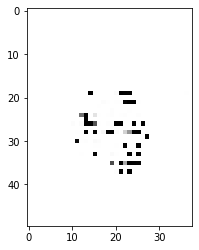

In [8]:
# (4) show word images
plt.subplot(len(line), len(line), 1)
plt.imshow(img, cmap='gray')


BBox(x=6, y=18, w=28, h=21)


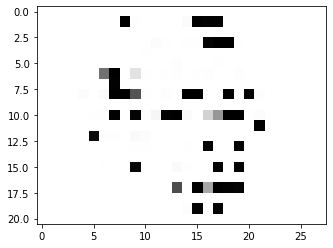

In [9]:
for i, word in enumerate(line):
  print(word.bbox)
  plt.subplot(len(line), len(line), i + 1)
  plt.imshow(word.img, cmap='gray')
plt.savefig("jemp.jpg")
plt.show()
